In [1]:
#importing Required Libraries to run code
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

### Step 1 - Read Images

In [2]:
#reading image paths with glob
vehicle_image_arr = glob.glob('./vehicles/vehicles/*/*.png')

# read images and append to list
vehicle_images_original=[]
for imagePath in vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    vehicle_images_original.append(rgbImage)

print('Reading of Vehicle Images Done')

non_vehicle_image_arr = glob.glob('./non-vehicles/non-vehicles/*/*.png')


non_vehicle_images_original=[]
for imagePath in non_vehicle_image_arr:
    readImage=cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
    non_vehicle_images_original.append(rgbImage)

print("Reading of Non Vehicle Images Done")

print("No of Vehicle Images Loaded -"+ str(len(vehicle_image_arr)))
print("No of Non-Vehicle Images Loaded -"+ str(len(non_vehicle_images_original)))

Reading of Vehicle Images Done
Reading of Non Vehicle Images Done
No of Vehicle Images Loaded -8792
No of Non-Vehicle Images Loaded -8968


Shape of Vehicle Image(64, 64, 3)
Shape of Non Vehicle Image(64, 64, 3)


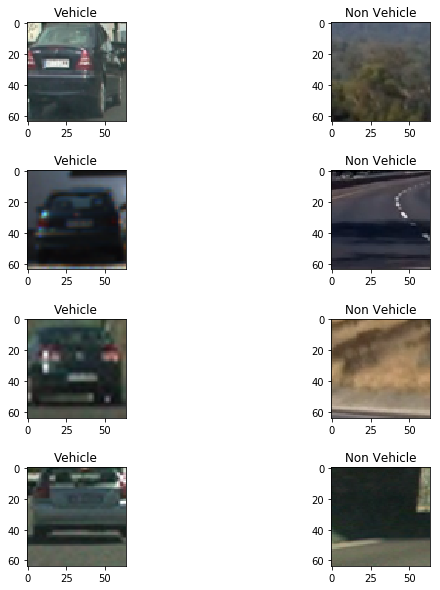

In [3]:
# Visualizing the Vehicle and Non Vehicle Images

f, axes = plt.subplots(4,2, figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

for index in range(4):
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,1].set_title("Non Vehicle")
print("Shape of Vehicle Image" +  str(vehicle_images_original[vehicle].shape))
print("Shape of Non Vehicle Image" +  str(non_vehicle_images_original[non_vehicle].shape))

### Step 2- Extract Features

### Step 2.1 - Color Spaces

In [131]:
### Extract Color Space

#creating a Histogram
def ExtractColorHistogram(image, nbins=32, bins_range=(0,255), resize=None):
    if(resize !=None):
        image= cv2.resize(image, resize)
    zero_channel= np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    first_channel= np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    second_channel= np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    return zero_channel,first_channel, second_channel

#Find Center of the bin edges
def FindBinCenter(histogram_channel):
    bin_edges = histogram_channel[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return bin_centers

#Extracting Color Features from bin lengths
def ExtractColorFeatures(zero_channel, first_channel, second_channel):
    return np.concatenate((zero_channel[0], first_channel[0], second_channel[0]))


No of features are 384


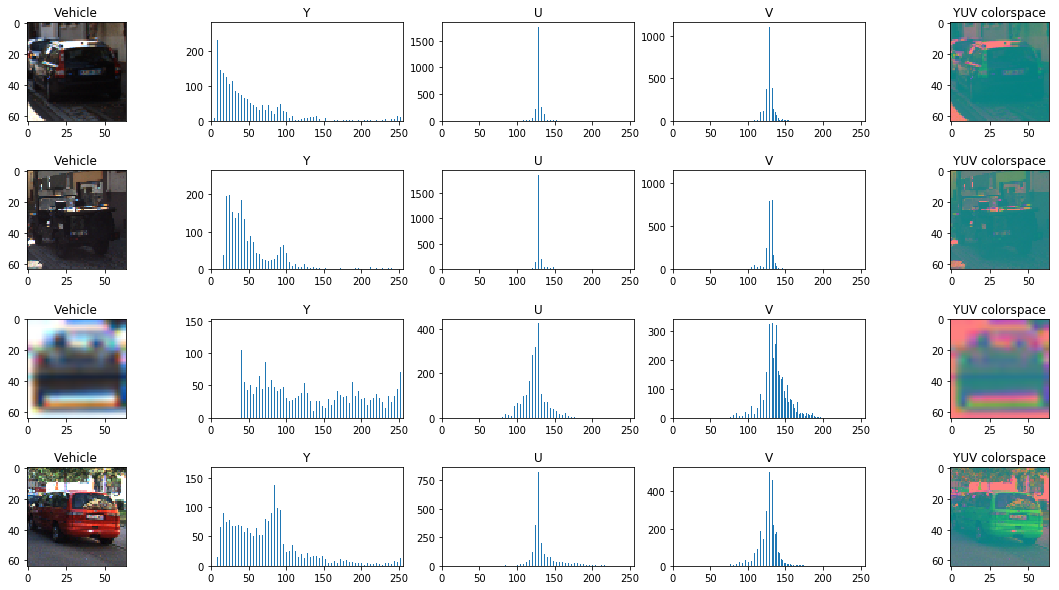

In [124]:
# Checking Color Features for Vehicles

f, axes= plt.subplots(4,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)

for index in range(4):
    
    vehicle=random.randint(0, len(vehicle_images_original)-1)
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    
    coloredImage= cv2.cvtColor(vehicle_images_original[vehicle],cv2.COLOR_RGB2YUV)
    r,g,b = ExtractColorHistogram(coloredImage,128)
   
    center= FindBinCenter(r)
    axes[index,0].imshow(vehicle_images_original[vehicle])
    axes[index,0].set_title("Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("Y")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("U")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("V")
    axes[index,4].imshow(coloredImage)
    axes[index,4].set_title("YUV colorspace")
    
features = ExtractColorFeatures(r,g,b)
print("No of features are "+ str(len(features)))
    


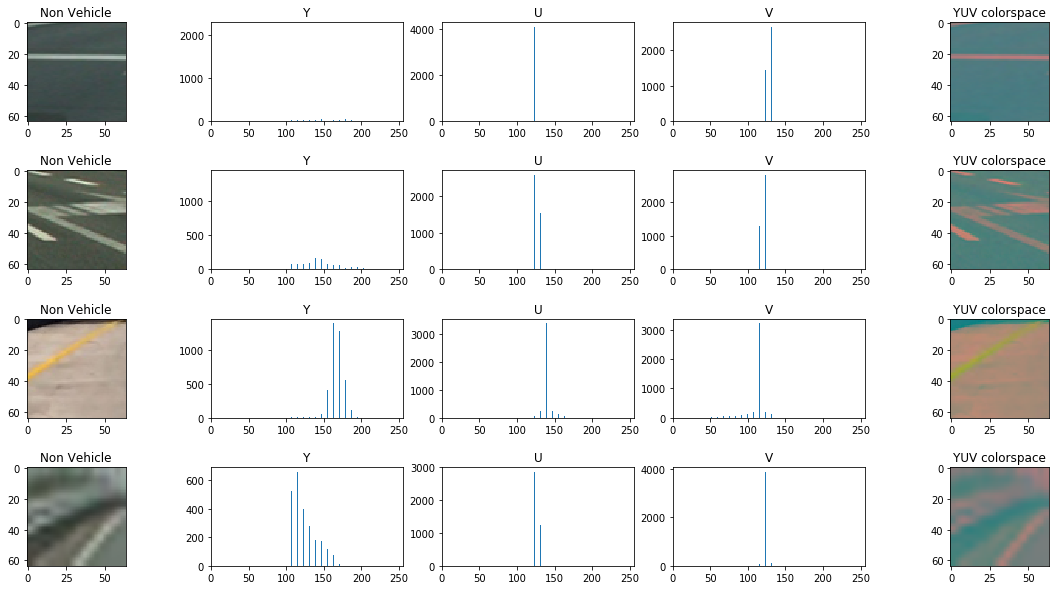

In [126]:
# Checking Color Features for Non Vehicles

f, axes= plt.subplots(4,5, figsize=(20,10))
f.subplots_adjust(hspace=0.5)

for index in range(4):
    non_vehicle=random.randint(0, len(non_vehicle_images_original)-1)
    coloredImage= cv2.cvtColor(non_vehicle_images_original[non_vehicle],cv2.COLOR_RGB2YUV)
    r,g,b = ExtractColorHistogram(coloredImage)
    
    center= FindBinCenter(r)
    axes[index,0].imshow(non_vehicle_images_original[non_vehicle])
    axes[index,0].set_title("Non Vehicle")
    axes[index,1].set_xlim(0,256)
    axes[index,1].bar(center,r[0])
    axes[index,1].set_title("Y")
    axes[index,2].set_xlim(0,256)
    axes[index,2].bar(center,g[0])
    axes[index,2].set_title("U")
    axes[index,3].set_xlim(0,256)
    axes[index,3].bar(center,b[0])
    axes[index,3].set_title("V")
    axes[index,4].imshow(coloredImage)
    axes[index,4].set_title("YUV colorspace")


### Step 2.2 - Spatial Binning

In [7]:
#Resizing Image to extract features, so as to reduce the feature vector size
def SpatialBinningFeatures(image,size):
    image= cv2.resize(image,size)
    return image.ravel()

In [134]:
#testing the spatial binning

featureList=SpatialBinningFeatures(vehicle_images_original[1],(16,16))
print("No of features before spatial binning",len(vehicle_images_original[1].ravel()))
print("No of features after spatial binning",len(featureList))

No of features before spatial binning 12288
No of features after spatial binning 768


### Step 2.3 - HOG ( Histogram of Oriented Gradients)

In [9]:
# General method to extact the HOG of the image

def GetFeaturesFromHog(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualise=False, feature_vector=feature_vector_flag)
        return hog_features

Feature Vector Length Returned is  1764
No of features that can be extracted from image  4096


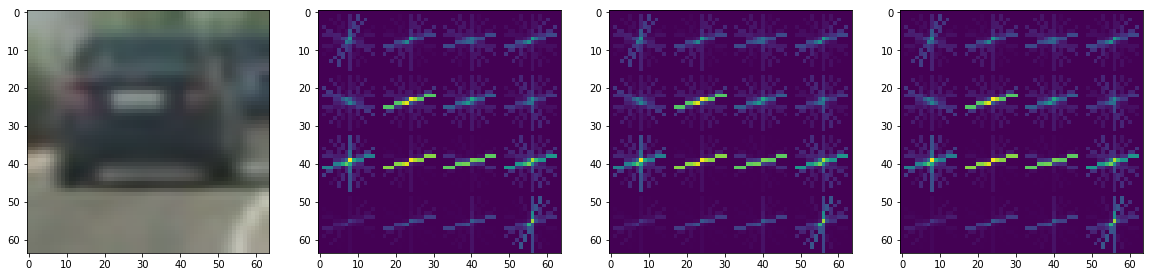

In [129]:
#testing HOG on test images

image=vehicle_images_original[1]
image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
image_channel_0=image[:,:,0]
image_channel_1=image[:,:,0]
image_channel_2=image[:,:,0]

feature_0,hog_img_0=GetFeaturesFromHog(image_channel_0,9,2,16,visualise=True,feature_vector_flag=True)
feature_1,hog_img_1=GetFeaturesFromHog(image_channel_1,9,2,16,visualise=True,feature_vector_flag=True)
feature_2,hog_img_2=GetFeaturesFromHog(image_channel_2,9,2,16,visualise=True,feature_vector_flag=True)

f, axes= plt.subplots(1,4,figsize=(20,10))
axes[0].imshow(vehicle_images_original[1])
axes[1].imshow(hog_img_0)
axes[2].imshow(hog_img_1)
axes[3].imshow(hog_img_2)


print("Feature Vector Length Returned is ",len(feature1))
print("No of features that can be extracted from image ",len(img.ravel()))

### Step 3- Generate Features Data


In [11]:
#Convert Image Color Space. Note the colorspace parameter is like cv2.COLOR_RGB2YUV
def ConvertImageColorspace(image, colorspace):
    return cv2.cvtColor(image, colorspace)

In [130]:
# Method to extract the features based on the choices as available in step 2

def ExtractFeatures(images,orientation,cellsPerBlock,pixelsPerCell, convertColorspace=False):
    featureList=[]
    imageList=[]
    for image in images:
        if(convertColorspace==True):
            image= cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        local_features_1=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_2=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, False, True)
        local_features_3=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, False, True)
        x=np.hstack((local_features_1,local_features_2,local_features_3))
        featureList.append(x)
    return featureList

#### Extracting the Features of the Dataset

In [135]:
%%time

orientations=9
cellsPerBlock=2
pixelsPerBlock=16
convertColorSpace=True
vehicleFeatures= ExtractFeatures(vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)
nonVehicleFeatures= ExtractFeatures(non_vehicle_images_original,orientations,cellsPerBlock,pixelsPerBlock, convertColorSpace)


Wall time: 40.5 s


In [14]:

featuresList= np.vstack([vehicleFeatures, nonVehicleFeatures])
print("Shape of features list is ", featuresList.shape)
labelList= np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
print("Shape of label list is ", labelList.shape)


Shape of features list is  (17760, 972)
Shape of label list is  (17760,)


### Step 4- Data Preprocessing

### Step 4.1 - Splitting Data into Training and Test Set

In [15]:
# train test split of data

from sklearn.model_selection import train_test_split

X_train,  X_test,Y_train, Y_test = train_test_split(featuresList, labelList, test_size=0.2, shuffle=True)



### Step 4.2 - Normalization and Scaling of Data

In [16]:
# normalization and scaling

from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

### Step 5- Define and Train a classifier

In [136]:
%%time

# Train a Linear SVM classifer
from sklearn.svm import LinearSVC
classifier1= LinearSVC()
classifier1.fit(X_train,Y_train)
print("Accuracy of SVC is  ", classifier1.score(X_test,Y_test) )

Accuracy of SVC is   0.9878941441441441
Wall time: 1.28 s


### Step 6 - Sliding Window

In [19]:
# function to draw sliding Windows

import matplotlib.image as mpimg

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    
    for bbox in bboxes:
        r=random.randint(0,255)
        g=random.randint(0,255)
        b=random.randint(0,255)
        color=(r, g, b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [20]:
# function to find the windows on which we are going to run the classifier

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
   
    if x_start_stop[0] == None:
        x_start_stop[0]=0
    if x_start_stop[1] == None:
        x_start_stop[1]=img.shape[1]
    if y_start_stop[0] ==  None:
        y_start_stop[0]= 0
    if y_start_stop[1] ==  None:
        y_start_stop[1]=img.shape[0]
    
    
    window_list = []
    image_width_x= x_start_stop[1] - x_start_stop[0]
    image_width_y= y_start_stop[1] - y_start_stop[0]
     
    windows_x = np.int( 1 + (image_width_x - xy_window[0])/(xy_window[0] * xy_overlap[0]))
    windows_y = np.int( 1 + (image_width_y - xy_window[1])/(xy_window[1] * xy_overlap[1]))
    
    modified_window_size= xy_window
    for i in range(0,windows_y):
        y_start = y_start_stop[0] + np.int( i * modified_window_size[1] * xy_overlap[1])
        for j in range(0,windows_x):
            x_start = x_start_stop[0] + np.int( j * modified_window_size[0] * xy_overlap[0])
            
            x1 = np.int( x_start +  modified_window_size[0])
            y1= np.int( y_start + modified_window_size[1])
            window_list.append(((x_start,y_start),(x1,y1)))
    return window_list
    

In [21]:
# function that returns the refined Windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car

def DrawCars(image,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64))
            
            f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
        
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

In [22]:
# trying out SubSampling using HOG but not able to go through as feature size is not the same.

def DrawCarsOptimised(image, image1, image2,windows, converColorspace=False):
    refinedWindows=[]
    for window in windows:
        
        start= window[0]
        end= window[1]
        clippedImage=image[start[1]:end[1], start[0]:end[0]]
        clippedImage1=image1[start[1]:end[1], start[0]:end[0]]
        clippedImage2=image2[start[1]:end[1], start[0]:end[0]]
        
        if(clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1]!=0):
            
            clippedImage=cv2.resize(clippedImage, (64,64)).ravel()
            clippedImage1=cv2.resize(clippedImage1, (64,64)).ravel()
            clippedImage2=cv2.resize(clippedImage2, (64,64)).ravel()
            
            #f1=ExtractFeatures([clippedImage], 9 , 2 , 16,converColorspace)
            f1= np.hstack((clippedImage,clippedImage1,clippedImage2))
            f1=scaler.transform(f1.reshape(1,-1))   
            print(f1.shape)
            predictedOutput=classifier1.predict([f1[0]])
            if(predictedOutput==1):
                refinedWindows.append(window)
        
    return refinedWindows

Total No of windows are  470


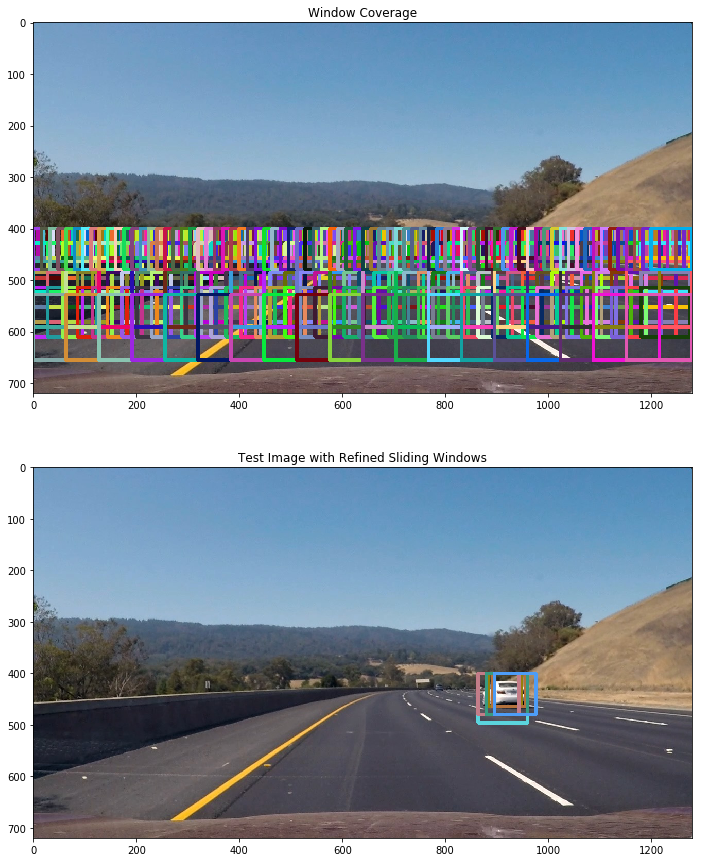

In [142]:
#testing our functions of slide_window and draw window. Defining here dummy windows

image = mpimg.imread('test3.jpg')

windows1 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,464], 
                    xy_window=(64,64), xy_overlap=(0.15, 0.15))
windows4 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,480], 
                    xy_window=(80,80), xy_overlap=(0.2, 0.2))
windows2 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,612], 
                    xy_window=(96,96), xy_overlap=(0.3, 0.3))
windows3 = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[400,660], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))


windows = windows1 + windows2 +  windows3 + windows4
print("Total No of windows are ",len(windows))
refinedWindows=DrawCars(image,windows, True)



f,axes= plt.subplots(2,1, figsize=(30,15))

window_img = draw_boxes(image, windows) 

axes[0].imshow(window_img)
axes[0].set_title("Window Coverage")

window_img = draw_boxes(image, refinedWindows) 

axes[1].set_title("Test Image with Refined Sliding Windows")
axes[1].imshow(window_img)


### Step 7 - Applying Heatmap 

In [25]:
# function to increase the pixel by one inside each box

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap 

In [26]:
# applying a threshold value to the image to filter out low pixel cells

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [27]:
# find pixels with each car number and draw the final bounding boxes

from scipy.ndimage.measurements import label
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

 Number of Cars found -  1


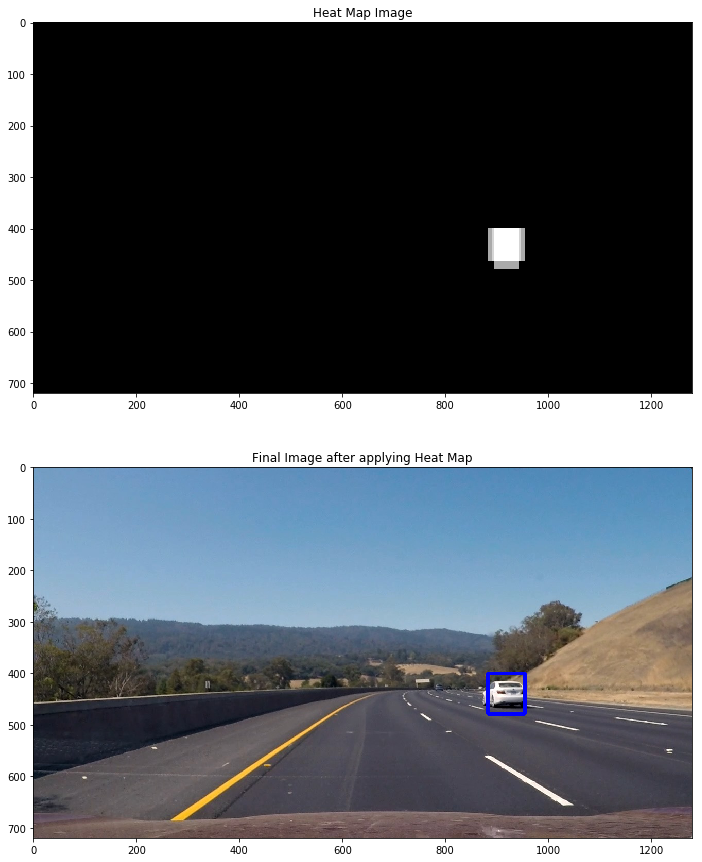

In [151]:
#testing our heat function

heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,refinedWindows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

heat_image=heatmap

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(" Number of Cars found - ",labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

f,axes= plt.subplots(2,1, figsize=(30,15))
axes[0].imshow(heat_image,cmap='gray')
axes[0].set_title("Heat Map Image")
axes[1].imshow(draw_img)
axes[1].set_title("Final Image after applying Heat Map")

### Step 8 - Averaging Rectangles over Frames

In [160]:
# Defining a class to store the refined frames found from the last 15 frames

class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]


### Step 9 - Defining Pipeline

In [156]:
#defining the Parameters required for the pipeline to run

orientation=9 # No of orientations of HOG
cellsPerBlock=2 # No of cells per block
pixelsPerCell=16 # No of pixels per cell
xy_window=(64, 64) # window Size
xy_overlap=(0.15, 0.15) # Window Overlap. Please note this is different as provided by Udacity. Overlap of 0.15 means my windows are 85% overlapping with each other
x_start_stop=[0, image.shape[1]] # X Coordinates to start and stop search
y_start_stop=[400, 660] # Y Coordinates to start and stop search

# Window 1- Size - 64x64 , Overlap-85%
windows_normal = slide_window(image, x_start_stop, [400,464], 
                    xy_window, xy_overlap)

# Window 2- Size - 80x80 , Overlap-80%
xy_window_1_25= (80,80)
xy_window_1_25_overlap=(0.2, 0.2)    
windows_1_25 = slide_window(image, x_start_stop, [400,480], 
                    xy_window_1_25, xy_window_1_25_overlap)

# Window 3- Size - 96x96 , Overlap-70%
xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.3, 0.3)    
windows_1_5 = slide_window(image, x_start_stop, [400,612], 
                    xy_window_1_5, xy_window_1_5_overlap)

# Window 4- Size - 128x128 , Overlap-50%
xy_window_twice_overlap=(0.5, 0.5)    
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [400,660], 
                    xy_window_twice, xy_window_twice_overlap)

# Total Windows - 470
windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are ",len(windows))

No of Windows are  470


In [168]:
# Defining a pipeline for Video Frame Processing
# Note here the track of last 15 frames is kept

def Pipeline(image):
#     features,hog_image=GetFeaturesFromHog(image[:,:,0],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features1,hog_image1=GetFeaturesFromHog(image[:,:,1],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     features2,hog_image2=GetFeaturesFromHog(image[:,:,2],orientation,cellsPerBlock,pixelsPerCell, visualise= True, feature_vector_flag=False)
#     refinedWindows=DrawCarsOptimised(hog_image,hog_image1,hog_image2,windows, True)
    
#     image=find_cars(image, 400, 528, 1,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 560, 1.25,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 588, 1.5,  orientation, pixelsPerCell, cellsPerBlock)
#     image=find_cars(image, 400, 660, 2,  orientation, pixelsPerCell, cellsPerBlock)
    rand= random.randint(0,1)
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:
        refinedWindows=DrawCars(image,windows, True)
        if len(refinedWindows) > 0:
            keepTrack.AddWindows(refinedWindows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    
    
    heatmap = apply_threshold(heat, 25 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [154]:
# Defining a different pipeline to process the images as we do not want to keep track of previous frames here

def PipelineImage(image):

    refinedWindows=DrawCars(image,windows, True)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    heatmap = apply_threshold(heat, 4)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

### Step 10- Testing Pipeline on Test Images

Wall time: 10.1 s


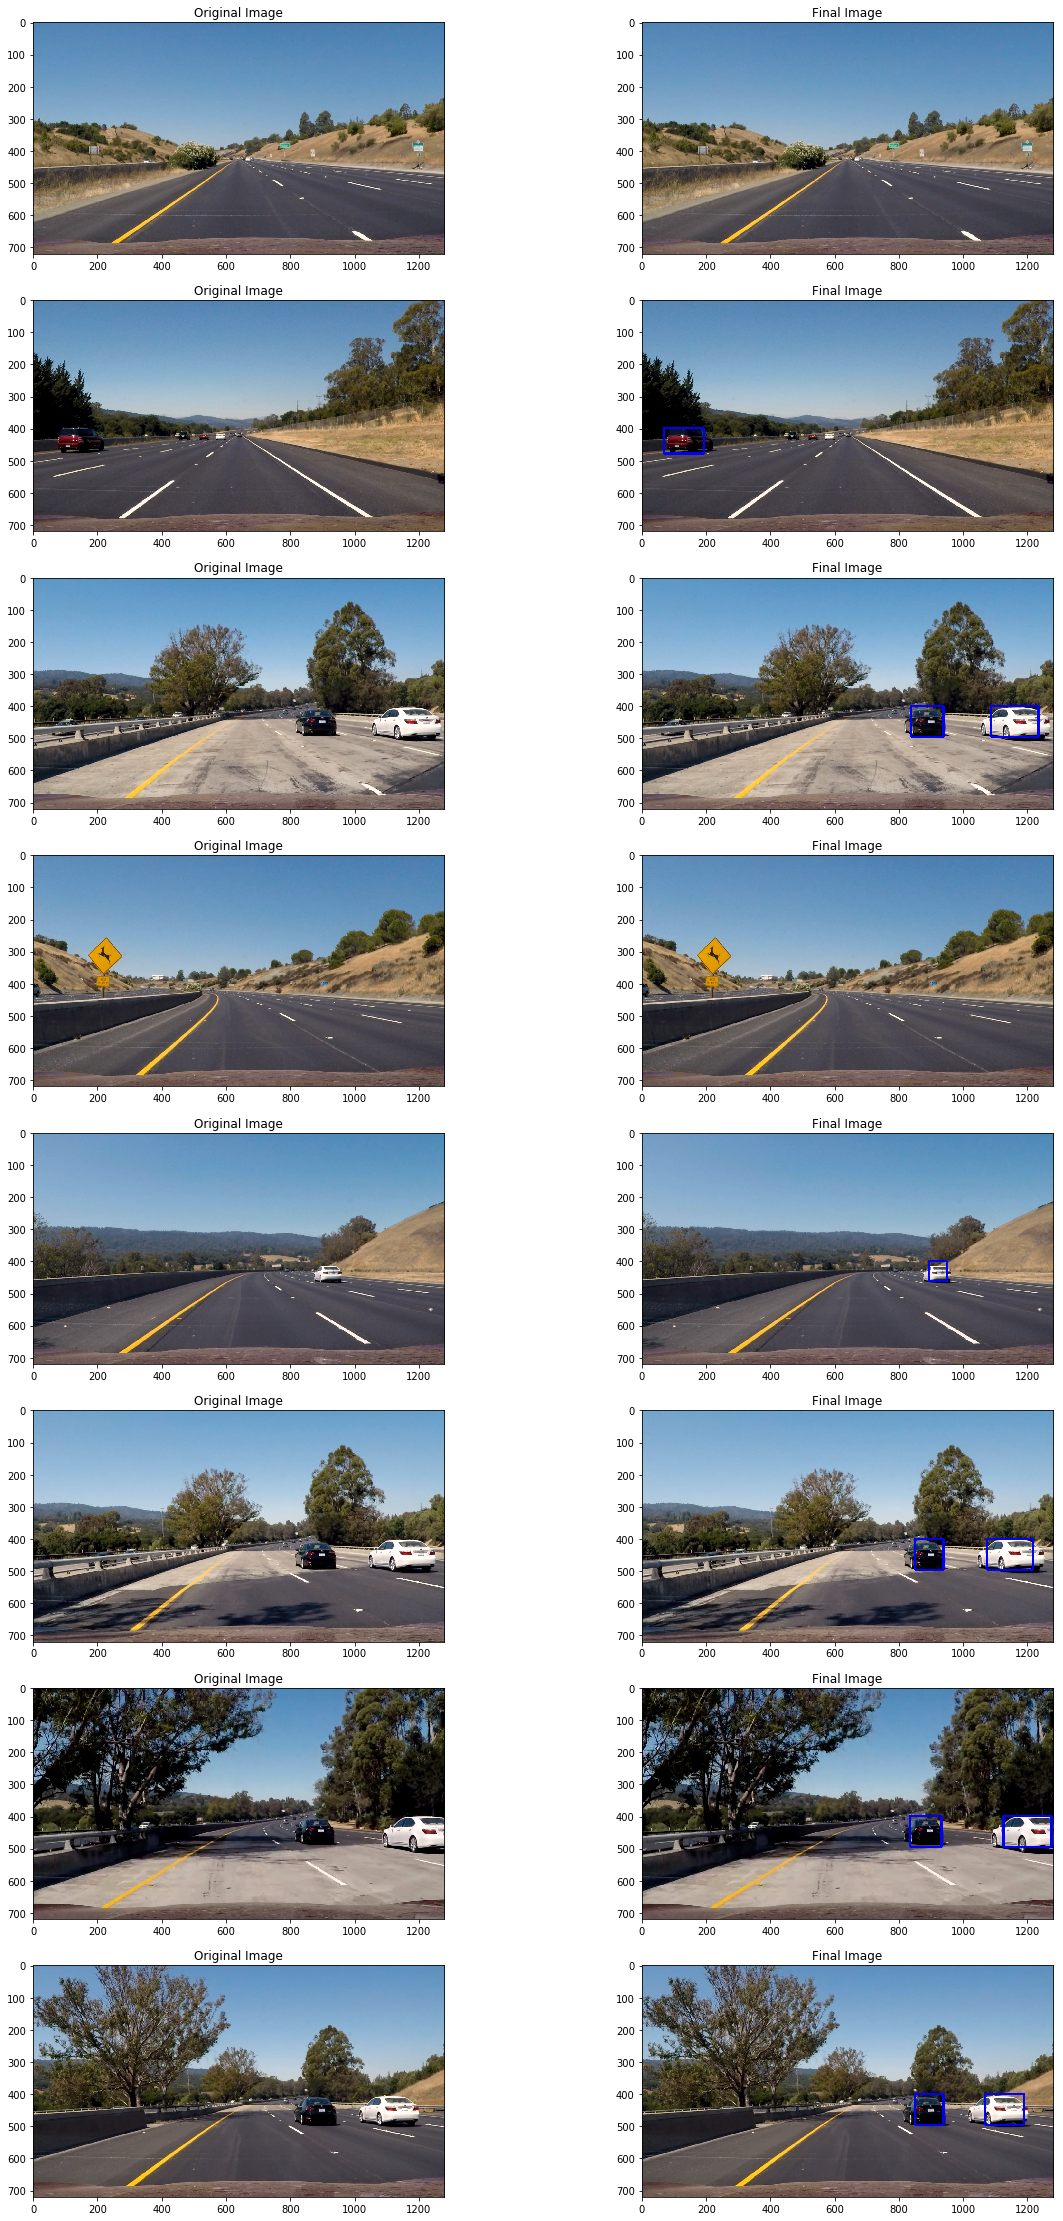

In [163]:
%%time
test_images= glob.glob("./test_images/*.jpg")
f, axes= plt.subplots(8,2, figsize=(20,40))

for index,image in enumerate(test_images):
    image = cv2.imread(image)
    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    finalPic = PipelineImage(image)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(finalPic)
    axes[index,1].set_title("Final Image")


### Step 11- Testing Pipeline on Test Video

In [170]:
keepTrack = KeepTrack()
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'final video for writeup.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(Pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

[MoviePy] >>>> Building video final video for writeup.mp4
[MoviePy] Writing video final video for writeup.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:05<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final video for writeup.mp4 

Wall time: 13min 7s
